**Monte-Carlo and Temporal Difference**

In this example, we are going to compare two algorithms that work model-free to estimate the value function: every-visit Monte Carlo, and Temporal Difference. We will use the Cliff:

![alt text](cliff_problem.png "Title")

Let us start with the imports. We use numpy, tabulate, matplotlib and gym in this exercise.

In [1]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import gym.spaces as gs
except:
    !pip install gym
    import gym.spaces as gs

The next thing we do is to seed the random number generator.This is done to ensure that the results are reproducible.At this point, this is not strictly necessary, but it is good practice to do so (and when working with Deep Reinforcement Learning, it is absolutely necessary).

In [2]:
seed = 1234
rng = np.random.default_rng(1234)

We use the Cliff class that we have already used before.

In [3]:
class grid(object):  # Create the GridWorld class

    def __init__(self, dims=(3, 3), seed=1234):
        self.dims = dims  # Gridworld dims (rows x cols)
        self.observation_space = gs.Box(low=np.array([0, 0]), high=np.array([self.dims[0] - 1, self.dims[1] - 1]), dtype=int, seed=seed)  # The observations are the coordinates of each grid cell
        self.action_space = gs.Discrete(4, seed=seed)  #  There are 4 possible actions: 0=up, 1=down, 2=left, 3=right
        self.init_state = (self.dims[0] - 1, 0)  # Initial state, always the same for simplicity: lower left corner
        self.target_state = (self.dims[0] - 1, self.dims[1] - 1)  # Target state: always the same for simplicity: lower right corner
        self.cliff_location = [(self.dims[0] - 1, i) for i in range(1, self.dims[1] - 1)]  # Lower row (except for target and initial state)
        self.state = None  # This is to store data later on

    def reset(self, randomize=False):  # Call this method to reset the environment
        if randomize:  # To use a random initial state
            self.state = self.observation_space.sample()
        else:
            self.state = self.init_state  # Use a fixed initial state
        return self.state

    def step(self, action):  # This method implements the environment transition

        action = np.squeeze(action).astype(int).item()  # Prepare action (make it an integer just in case)
        if action < 0 or action > 3:  # Check the action bounds
            raise RuntimeError('Action out of bounds')
        # Perform action to get next state (i.e., move the agent in the grid world)
        if action == 0:
            next_state = self.state + np.array([1, 0])  # Move down
        elif action == 1:
            next_state = self.state + np.array([-1, 0])  # Move up
        elif action == 2:
            next_state = self.state + np.array([0, -1])  # Move left
        elif action == 3:
            next_state = self.state + np.array([0, 1])  # Move right
        # Set the action bounds correctly, as we may end up out of the grid
        next_state = np.clip(next_state, np.zeros(2), np.array(self.dims) - 1).astype(int)
        # Check reward and termination condition
        reward, done = self.reward_done(next_state)
        self.state = next_state  # Change the state in the class
        return next_state, reward, done, {}  # Return next state, reward and whether episode has ended

    def from_index(self, index):  # Ancillary method: convert an index state to state coordinates
        return np.unravel_index(index, self.dims)

    def to_index(self, state):  # Ancillary method: convert state coordinates to index
        return np.ravel_multi_index(state, self.dims)

    def reward_done(self, state):
      if tuple(state) in self.cliff_location:  # We fall off the cliff
        reward = -100  # Highly penalizing reward: you die
        done = True  # Episode is terminated
      elif np.sum(np.abs(state - np.array(self.target_state))) < 1e-4:  # Final target found
        reward = 0  # Final reward is 0
        done = True  # Episode is terminated
      else:  # We haven't neither reached the target nor fallen off the cliff
        reward = -1  # Standard reward (takes another step)
        done = False  # Episode not terminated yet
      return reward, done

    def action_to_str(self, action):
      def ac2str(action):
        if action == 0:
          return 'down'
        if action == 1:
          return 'up'
        if action == 2:
          return 'left'
        if action == 3:
          return 'right'
      if isinstance(action, list):
        return [ac2str(a) for a in action]
      else:
        return ac2str(action)

Now, we can start with the algorithms. We will use the same number of episodes for both algorithms, and the same number of steps per episode. We will use a constant step size for both algorithms. We will also plot the error of the algorithms as a function of the number of episodes.

Obtaining MC prediction...
Obtaining TD prediction...


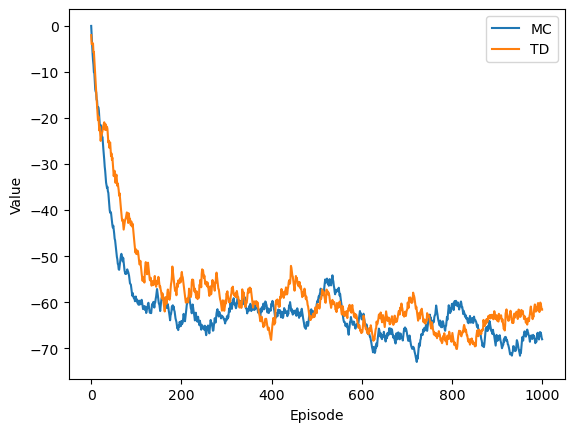

In [4]:
env = grid(dims=(4, 12), seed=seed)  # Environment to work
n_states = np.prod(env.dims)  # Number of states, |S|
n_actions = 4  # Number of actions, |A|
gamma = 0.9

# Predict using model-free RL methods (note that we cannot use PE, as we are not in infinite horizon!)
alpha = 0.02  # Update ratio: play around to see the effects on the variance and learning speed
n_episodes = 1000  # Episodes used to update

# Monte-Carlo
v_mc = np.zeros((n_episodes + 1, ))  # In this case, we only update for the initial state!
print('Obtaining MC prediction...')
for e in range(n_episodes):
  state = env.reset()
  done = False
  g_mc = 0
  k = 0
  while not done:
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    g_mc += reward * gamma ** k
    k += 1
    state = next_state
  v_mc[e + 1] = v_mc[e] + alpha * (g_mc - v_mc[e])


# Temporal Difference
v_td = np.zeros((n_episodes + 1, n_states))
print('Obtaining TD prediction...')

for e in range(n_episodes):
  state = env.reset()
  done = False
  v = v_td[e, :]
  while not done:
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    sti = env.to_index(state)
    nsti = env.to_index(next_state)
    v[sti] = v[sti] + alpha * (reward + gamma * v[nsti] - v[sti])  # TD update
    state = next_state
  v_td[e + 1] = v


# Plot the results
plt.plot(v_mc, label='MC')
plt.plot(v_td[:, env.to_index(env.init_state)], label='TD')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend(loc='best')
plt.show()